# Cell cycle analysis in Capolupo Human Dermal Fibroblasts

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import seaborn as sns 
import scanpy as sc
import scanpy.external as sce
import scipy.stats as ss

from pathlib import Path
from ripser import ripser
from scipy.spatial import distance
from tqdm import tqdm

import chunter as chnt
import ringity as rng

RANDOM_STATE = 240209

/Users/kelly/Documents/code/chunter2/.venv/lib/python3.12/site-packages/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if kerneltype is 'sf':
/Users/kelly/Documents/code/chunter2/.venv/lib/python3.12/site-packages/pygsp/filters/simpletight.py:82: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif kerneltype is 'wavelet':
/Users/kelly/Documents/code/chunter2/.venv/lib/python3.12/site-packages/pygsp/plotting.py:410: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("$\lambda$: laplacian's eigenvalues / graph frequencies")
/Users/kelly/Documents/code/chunter2/.venv/lib/python3.12/site-packages/pygsp/plotting.py:411: SyntaxWarning: invalid escape sequence '\h'
  ax.set_ylabel('$\hat{g}(\lambda)$: filter response')
/Users/kelly/Documents/code/chunter2/.venv/lib/python3.12/site-packages/persim/landscapes/visuals.py:310: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(ls[:, 0], ls[:, 1], label=f"$\lambda_{{{depth}}}

# Loading and pre-processing

In the first section we will use the same processing as the Lederer VeloCycle paper. 

In [3]:
# load the adata object from a file
adata = sc.read_h5ad("../Data/Capolupo/capolupo_fibroblasts_cycling.h5ad")

In [4]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.obs['total_log1p_counts'] = np.log(adata.obs['n_counts'] + 1)

In [5]:
sc.pp.filter_genes(adata, min_cells=int((adata.n_obs)*0.10))

In [6]:
# this is from the Lederer paper
adata = adata[:, (adata.layers["unspliced"].toarray().mean(0) > 0.1)].copy()
adata = adata[:, adata.layers["spliced"].toarray().mean(0) > 0.3].copy()

In [7]:
# Apply standard normalization
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# Log transform the data and scale
sc.pp.log1p(adata)
# scale data
# sc.pp.scale(adata)

# Diffusion and filtering for highly variable genes
# sce.pp.magic(adata, knn=4, t=1, random_state=RANDOM_STATE, n_jobs=4)

/var/folders/y7/jfktb_mn4qv99x02_jgb72tw0000gn/T/ipykernel_8146/3816533813.py:4: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
/Users/kelly/Documents/code/chunter2/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:589: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(


# Cell cycle scoring

In [8]:
dname_ccdata = Path('').absolute().parent/ "data"
fname_ccdata = dname_ccdata / "regev_lab_cell_cycle_genes.txt"
cell_cycle_genes = [x.strip() for x in open(fname_ccdata)]

# Separate out the components of the cell cycle genes
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

# score cells by cell cycle phase
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

       'EXO1', 'BLM', 'CASP8AP2', 'E2F8'],
      dtype='object')


In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

# Cell cycle analysis

In [10]:
# read csv with Data/Dotto/velocycle_small_cc_genes.csv
velocycle_small_cc_genes = pd.read_csv("../Data/Dotto/velocycle_small_cc_genes.csv")

# convert velocycle_small_cc_genes to a list
velocycle_small_cc_genes = velocycle_small_cc_genes['0'].tolist()

# subset adata.var_names to only include the genes in velocycle_small_cc_genes
adata_cc = adata[:, adata.var_names.isin(velocycle_small_cc_genes)].copy()

In [11]:
adata_cc

AnnData object with n_obs × n_vars = 1222 × 79
    obs: 'n_counts', 'total_log1p_counts', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'spliced', 'unspliced'

In [12]:
adata_cc = chnt.filter_cells_by_density(adata_cc, lower_percentile=2, upper_percentile=100)

In [13]:
chnt.scatter3D(adata_cc, comp = [0,1,2], color = 'density')

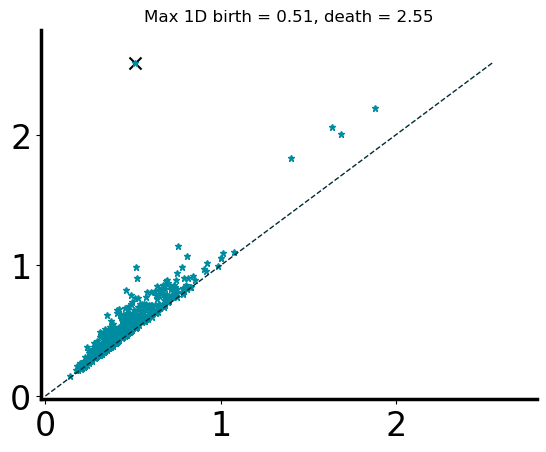

In [13]:
chnt.plot_diagram(adata_cc, comp = [0,1,2])

We will take the circular coordinate in the first 2 PCs since there is a clear circular structure already.

In [14]:
chnt.circular(adata_cc, comp = [0,1,2])

0.20265481472015381


AnnData object with n_obs × n_vars = 1196 × 79
    obs: 'n_counts', 'total_log1p_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'density', 'coords', 'log_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'circular'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'

In [15]:
chnt.scatter3D(adata_cc, comp = [0,1,2], color = 'coords', color_continuous_scale='hsv')

In [16]:
chnt.leadlag(adata_cc)

Harmonic Recentering


/opt/miniconda3/envs/chunter/lib/python3.12/site-packages/anndata/_core/storage.py:85: ImplicitModificationWarning:

Layer 'h_recenter' should not be a np.matrix, use np.ndarray instead.



Calculating Leadlag Matrix


100%|██████████| 79/79 [01:47<00:00,  1.36s/it]

Calculating Spectral Information
Aligning Data
Estimated starting gene: HELLS
Phase correction: 0.7123698625021647 rad


AnnData object with n_obs × n_vars = 1196 × 79
    obs: 'n_counts', 'total_log1p_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'density', 'coords', 'log_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_phase', 'gene_amp'
    uns: 'log1p', 'hvg', 'pca', 'circular', 'leadlag', 'leadlag_eigvals'
    obsm: 'X_pca'
    varm: 'PCs', 'leadlag_pcs'
    layers: 'spliced', 'unspliced', 'h_recenter'

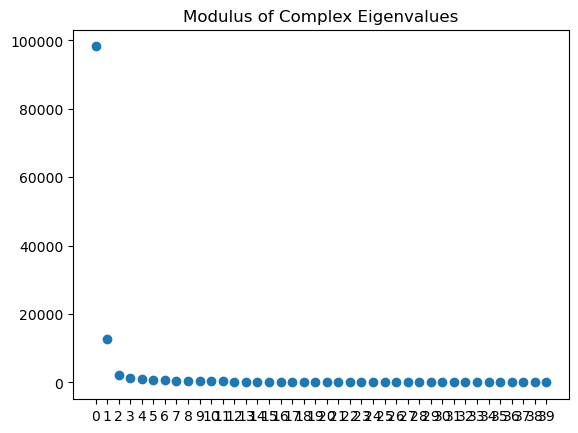

In [17]:
chnt.elbow_plot(adata_cc)

In [22]:
adata_cc.X =adata_cc.X.toarray()

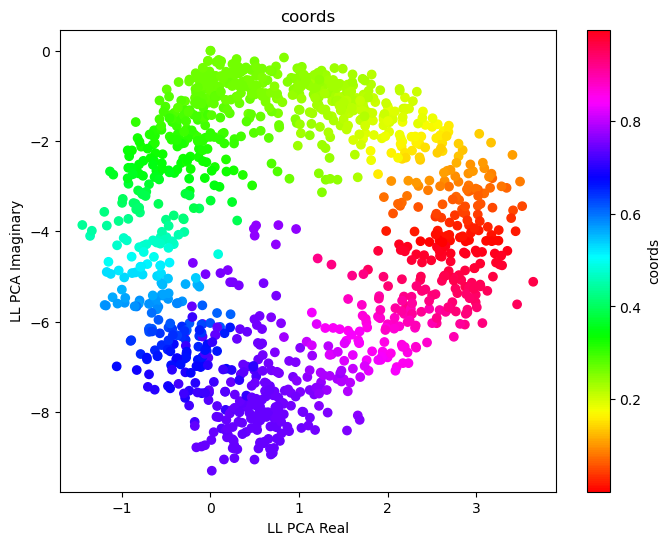

In [20]:
chnt.plot_2d(adata_cc, c = ['coords'], mode = 'll')

In [30]:
chnt.reparametrize(adata_cc,0.05)

AnnData object with n_obs × n_vars = 1196 × 79
    obs: 'n_counts', 'total_log1p_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'density', 'coords', 'log_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_phase', 'gene_amp'
    uns: 'log1p', 'hvg', 'pca', 'circular', 'leadlag', 'leadlag_eigvals'
    obsm: 'X_pca'
    varm: 'PCs', 'leadlag_pcs'
    layers: 'spliced', 'unspliced', 'h_recenter'

Text(0, 0.5, 'Log1p Total Expression')

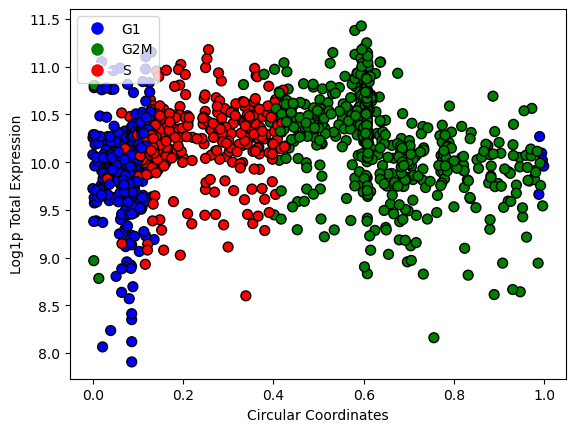

In [31]:
# map cc phase into a color
phases = adata_cc.obs['phase']

# color map phases
colors = {'G1': 'blue', 'G2M': 'green', 'S': 'red'}
phases = phases.map(colors)

# plot log of n_counts against coords using matplotlib
plt.scatter(adata_cc.obs['coords'], adata_cc.obs['total_log1p_counts'], s = 50, c = phases.values, edgecolors='k')

#  add a legend for the phases
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='G1', markerfacecolor='blue', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='G2M', markerfacecolor='green', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='S', markerfacecolor='red', markersize=10)],
           loc='upper left')
# label the axes 
plt.xlabel('Circular Coordinates')
plt.ylabel('Log1p Total Expression')

We can adjust the orientation and start point of the circular coordinate using the following functions

In [232]:
# chnt.reverse(adata_cc)
chnt.reparametrize(adata_cc, 0.05)

AnnData object with n_obs × n_vars = 1196 × 79
    obs: 'n_counts', 'total_log_counts', 'total_log1p_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'density', 'coords', 'log_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_phase', 'gene_amp'
    uns: 'log1p', 'hvg', 'pca', 'circular', 'leadlag', 'leadlag_eigvals'
    obsm: 'X_pca'
    varm: 'PCs', 'leadlag_pcs'
    layers: 'spliced', 'unspliced', 'h_recenter'

/Users/kelly/Documents/code/chunter2/src/chunter/chunter.py:1552: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/Users/kelly/Documents/code/chunter2/src/chunter/chunter.py:1582: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



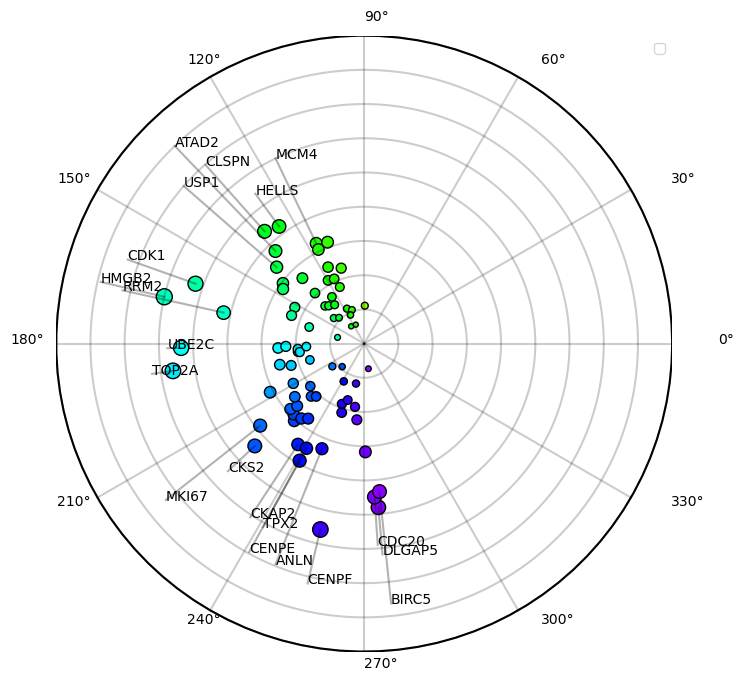

In [32]:
chnt.phase_plot(adata_cc, topk = 20, scale = 0.8)

In [50]:
top_genes = chnt.get_top_genes(adata_cc, k = 6 )

In [51]:
adata_cc

AnnData object with n_obs × n_vars = 1196 × 79
    obs: 'n_counts', 'total_log1p_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'density', 'coords', 'log_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_phase', 'gene_amp'
    uns: 'log1p', 'hvg', 'pca', 'circular', 'leadlag', 'leadlag_eigvals'
    obsm: 'X_pca'
    varm: 'PCs', 'leadlag_pcs'
    layers: 'spliced', 'unspliced', 'h_recenter'

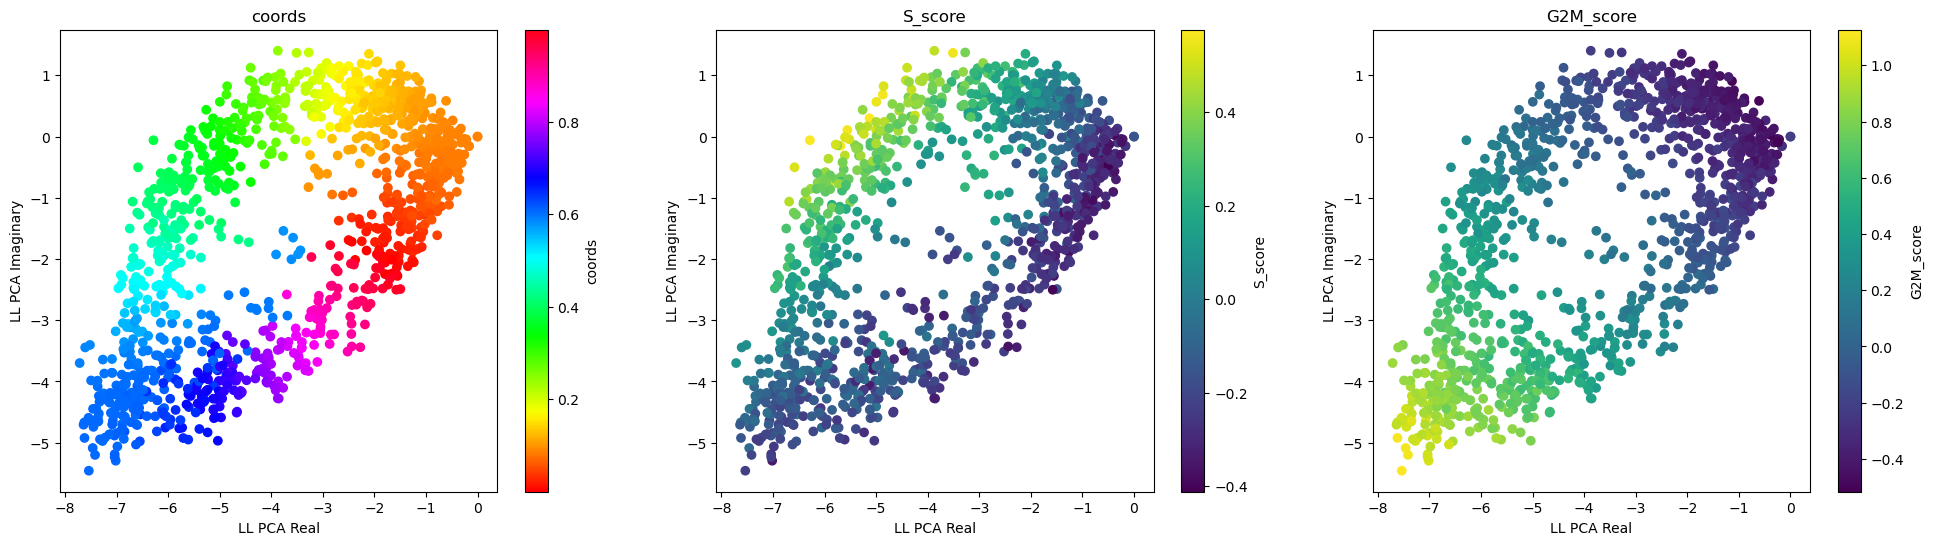

In [41]:
chnt.plot_2d(adata_cc, c = ['coords','S_score', 'G2M_score'], mode = 'll')

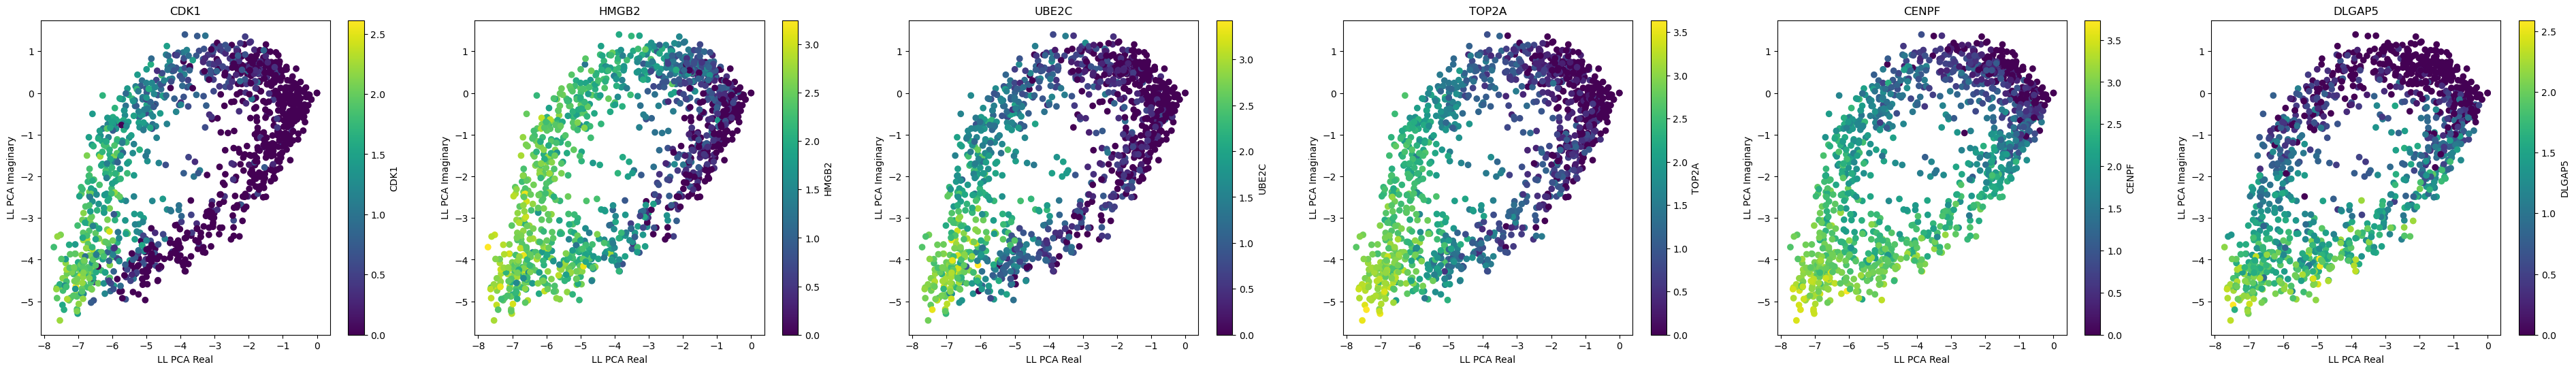

In [52]:
chnt.plot_2d(adata_cc, c = top_genes, mode = 'll')


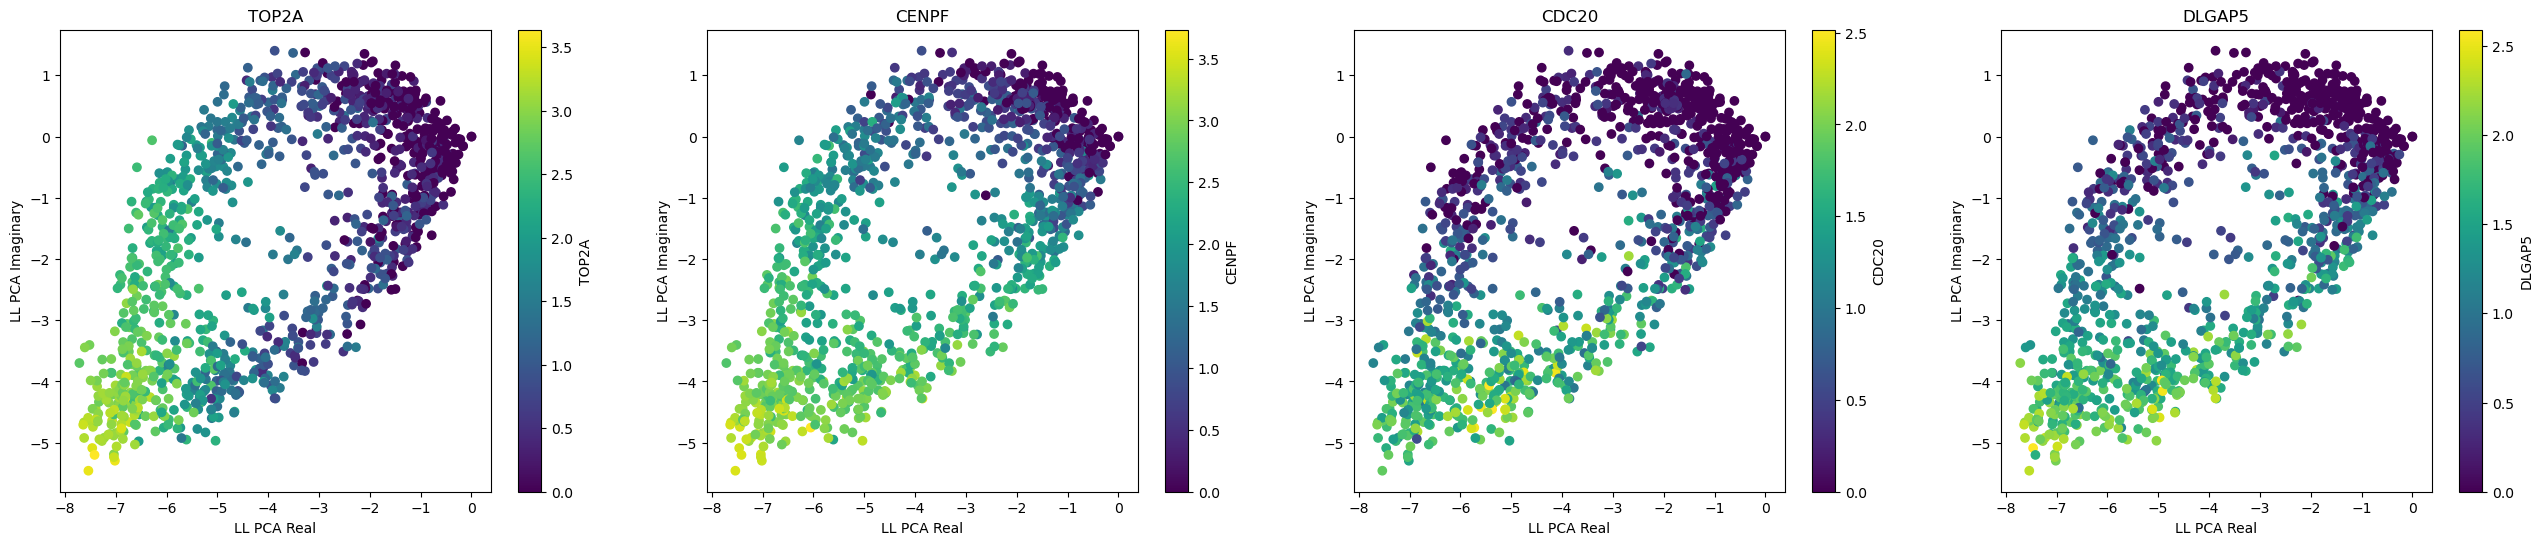

In [48]:
chnt.plot_2d(adata_cc, c = top_genes[4:], mode = 'll')

In [239]:
cc_genes = adata_cc.var_names

# determine which are S genes
s_genes = [x for x in cc_genes if x in s_genes]

# determine which are G2M genes
g2m_genes = [x for x in cc_genes if x in g2m_genes]


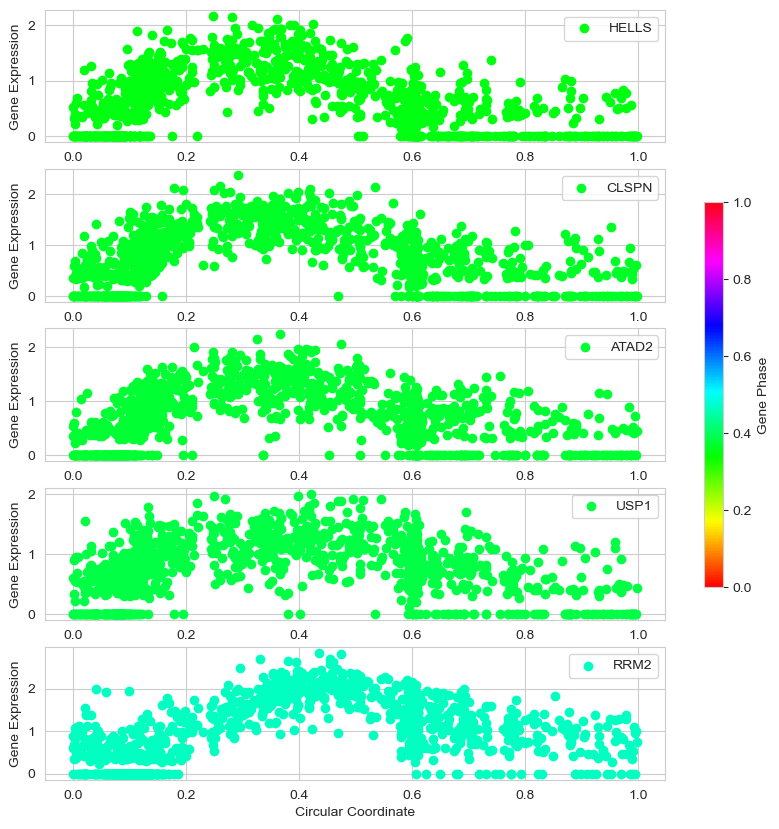

In [240]:
chnt.plot_top_genes(adata_cc[:,s_genes], k = 5)

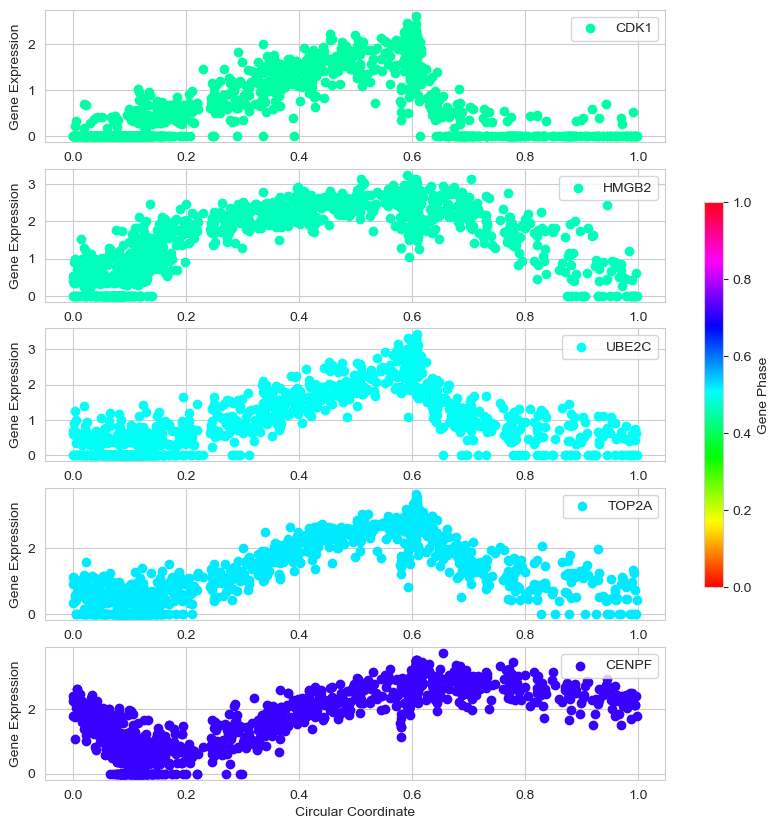

In [241]:
chnt.plot_top_genes(adata_cc[:,g2m_genes], k = 5)

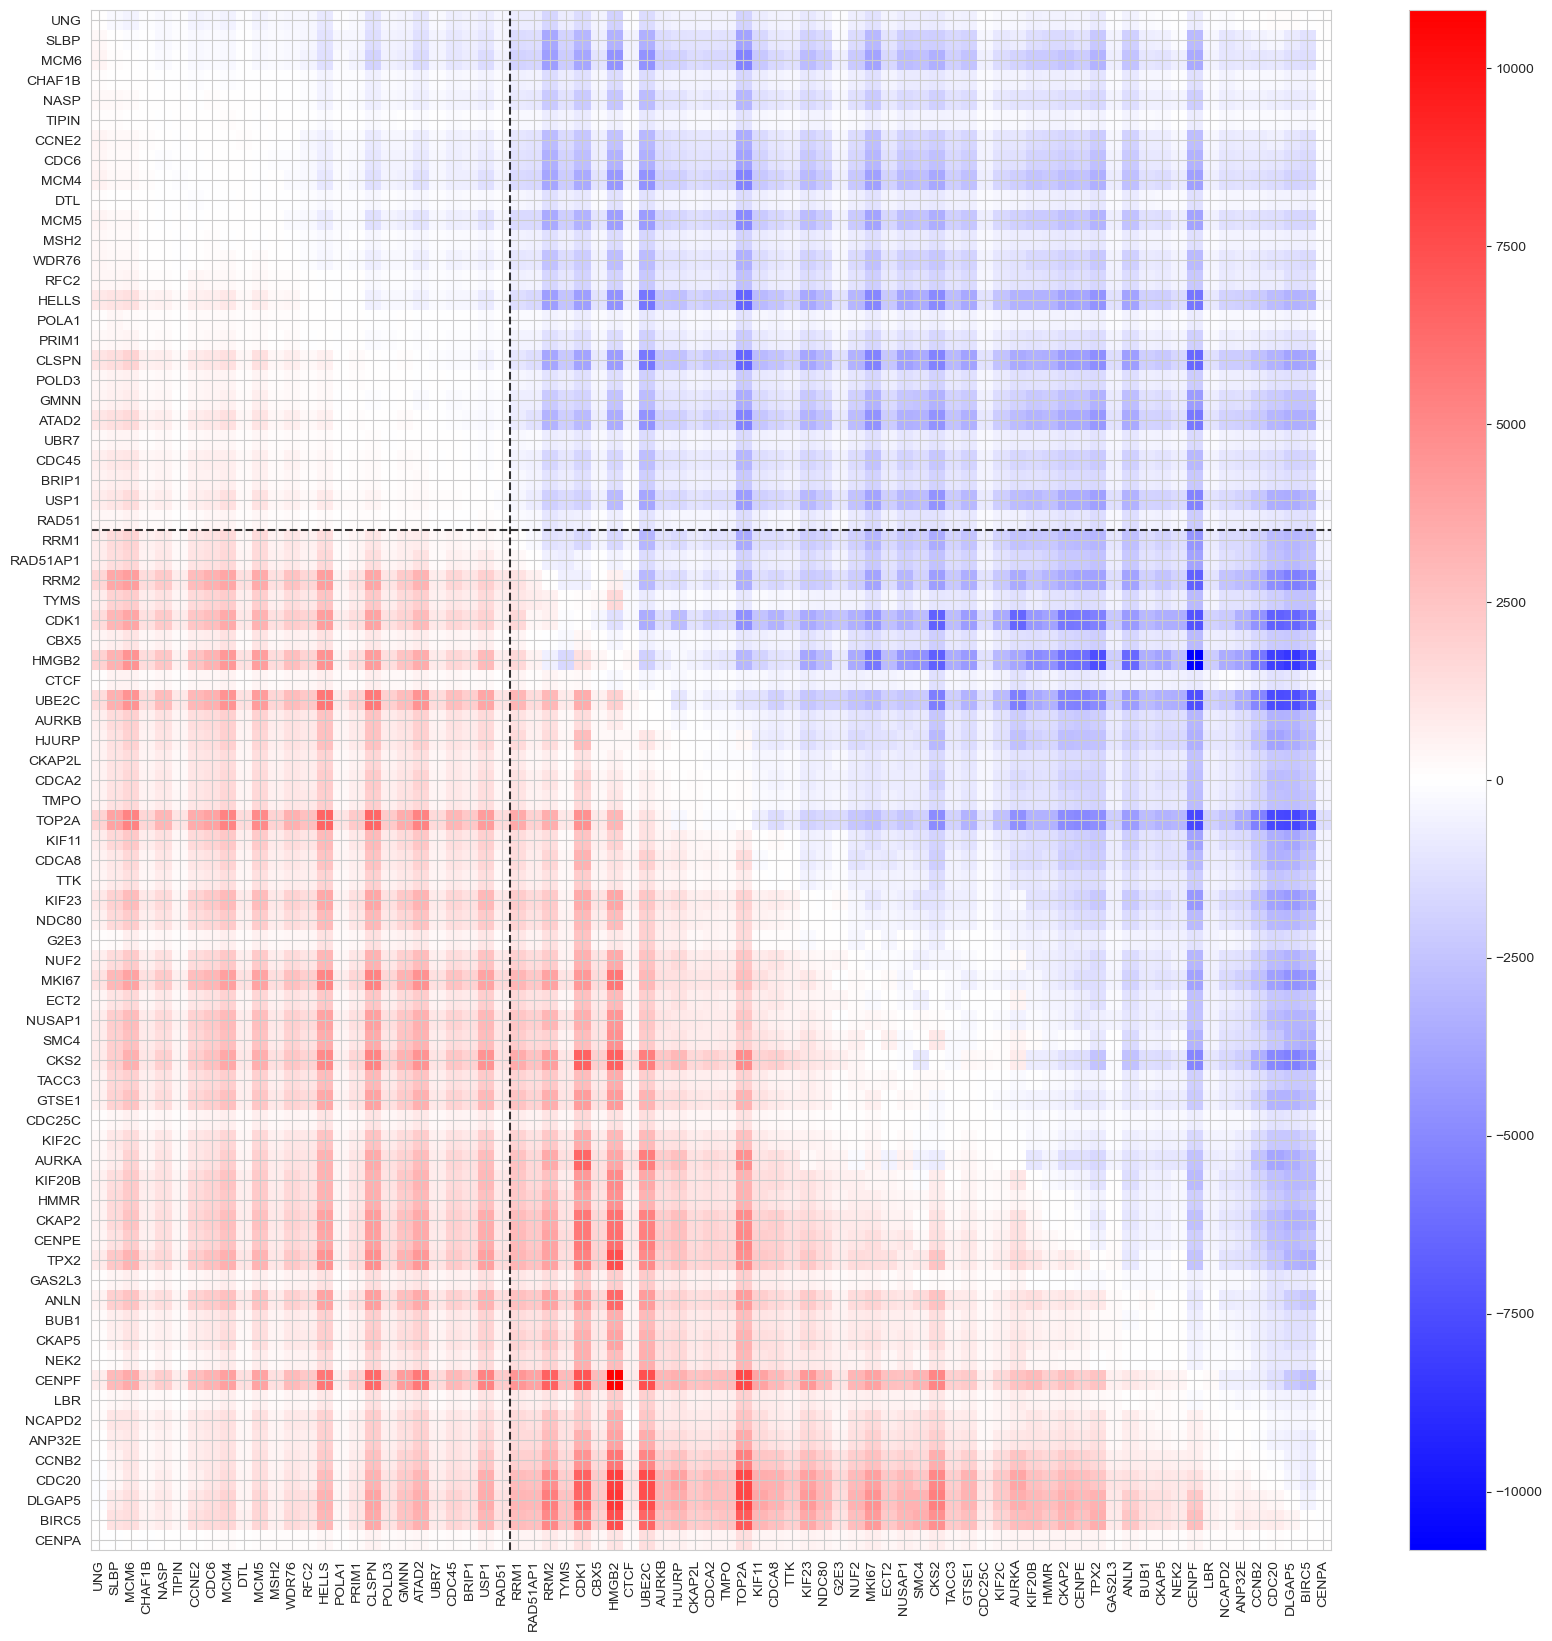

In [242]:
# return a list of adata_cc.var_names sorted by gene_phase
sorted_genes = list(adata_cc.var_names[np.argsort(adata_cc.var['gene_phase'])])
s = [x for x in sorted_genes if x in s_genes]
g2m = [x for x in sorted_genes if x in g2m_genes]

# get indices of s genes
s_indices = [list(adata_cc.var_names).index(x) for x in s]
# get indices of g2m genes
g2m_indices = [list(adata_cc.var_names).index(x) for x in g2m]

# concatenate the indices
total_indices = s_indices + g2m_indices
sorted_varnames = [adata_cc.var_names[x] for x in total_indices]

# initialize a large fig
plt.figure(figsize = (20,20))

# plot a heatmap of llm labelling x and y axis by total_top_genes
plt.imshow(adata_cc.uns['leadlag'][total_indices][:,total_indices], cmap = 'bwr', aspect = 'auto', interpolation='nearest')

# add a colorbar
plt.colorbar()


# label x axis and remove ticks
plt.xticks(ticks = np.arange(0,len(total_indices)), labels = adata_cc.var_names[total_indices], rotation = 90)

plt.yticks(ticks = np.arange(0,len(total_indices)), labels = adata_cc.var_names[total_indices])

# draw a vertical line at column 26
plt.axvline(x = 25.5, color = 'black', linestyle = '--', alpha = 0.8)

# draw a horizontal line at row 26
plt.axhline(y = 25.5, color = 'black', linestyle = '--', alpha = 0.8)

## Spliced vs Unspliced

In [150]:
cc_splicing = adata_cc.copy()

spliced_var_names = [x + '_spliced' for x in adata_cc.var_names]
unspliced_var_names = [x + '_unspliced' for x in adata_cc.var_names]

var_names = spliced_var_names + unspliced_var_names

# turn spliced and unspliced into arrays
spliced = adata_cc.layers['spliced']

unspliced = adata_cc.layers['unspliced']

# convert to non sparse arrays
spliced = spliced.toarray()
unspliced = unspliced.toarray()

# concatenate the spliced and unspliced var names along axis 1
con = np.concatenate([spliced, unspliced], axis = 1)

# change to float
con = con.astype('float32')


In [173]:
# create a new adata object with X = con, var_names and obs_names
adata = sc.AnnData(X = con, obs = adata_cc.obs)

adata.var_names = var_names

In [174]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# Log transform the data and scale
sc.pp.log1p(adata)

In [175]:
adata

AnnData object with n_obs × n_vars = 1154 × 158
    obs: 'n_genes', 'n_counts', 'S_score', 'G2M_score', 'phase', 'density', 'coords', 'log_counts'
    var: 'n_cells'
    uns: 'log1p'

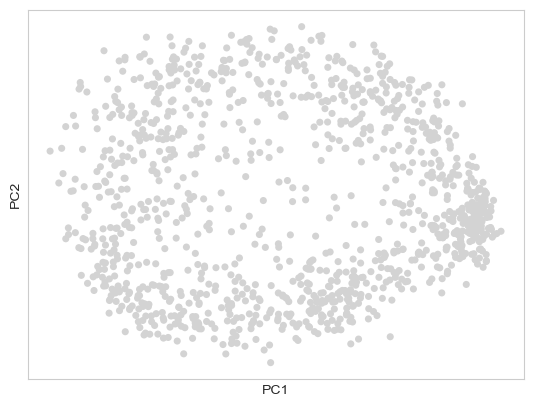

In [176]:
# run pca
sc.tl.pca(adata, n_comps=30, svd_solver='arpack', random_state=RANDOM_STATE)

# plot pca
sc.pl.pca(adata)


In [177]:
adata = chnt.filter_cells_by_density_iterative(adata, lower_percentile=1, upper_percentile=100,n_pcs=2, n_iter = 6)

Iteration 1: 1141 cells remain.
Iteration 2: 1128 cells remain.
Iteration 3: 1115 cells remain.
Iteration 4: 1102 cells remain.
Iteration 5: 1089 cells remain.
Iteration 6: 1077 cells remain.


In [178]:
chnt.scatter3D(adata)

In [167]:
sub=adata

In [181]:
chnt.circular(sub, comp = [0,1])

0.7206647396087646


AnnData object with n_obs × n_vars = 1013 × 158
    obs: 'n_genes', 'n_counts', 'S_score', 'G2M_score', 'phase', 'density', 'coords', 'log_counts', 'density_iter_1', 'density_iter_2', 'density_iter_3'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'circular'
    obsm: 'X_pca'
    varm: 'PCs'

In [183]:
chnt.reverse(sub)
chnt.reparametrize(sub,0.2)

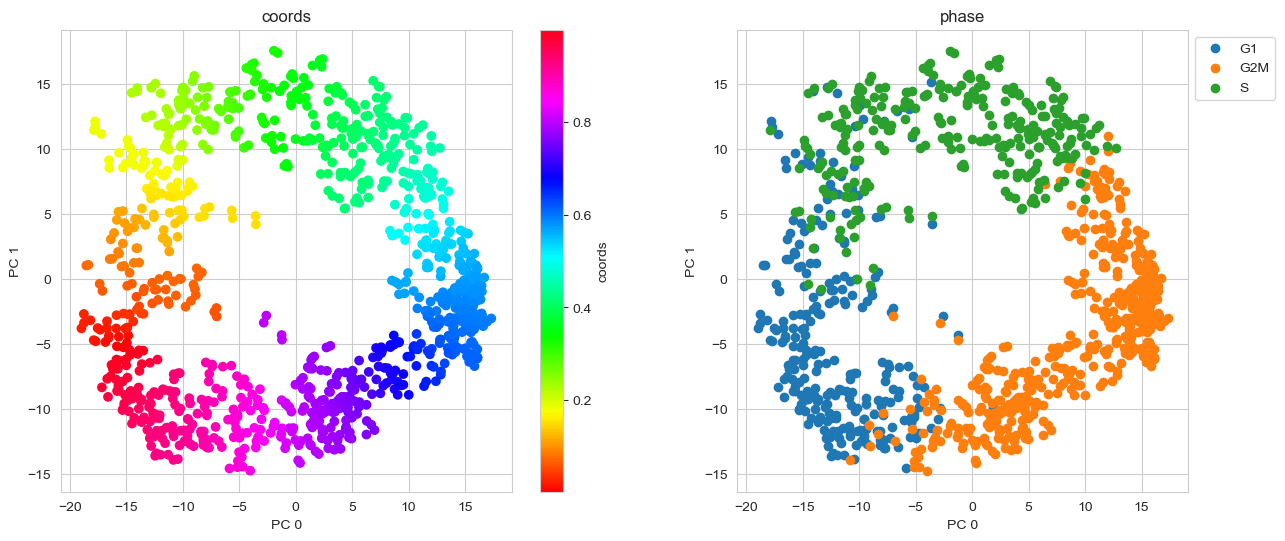

In [184]:
chnt.plot_2d(sub, c = ['coords','phase'], mode = 'pca')

In [185]:
chnt.leadlag(sub)

Harmonic Recentering
Calculating Leadlag Matrix


100%|██████████| 158/158 [04:54<00:00,  1.87s/it]

Calculating Spectral Information
Aligning Data
Estimated starting gene: MCM6_spliced
Phase correction: 5.890541133723423 rad


AnnData object with n_obs × n_vars = 1013 × 158
    obs: 'n_genes', 'n_counts', 'S_score', 'G2M_score', 'phase', 'density', 'coords', 'log_counts', 'density_iter_1', 'density_iter_2', 'density_iter_3'
    var: 'n_cells', 'gene_phase', 'gene_amp'
    uns: 'log1p', 'pca', 'circular', 'leadlag', 'leadlag_eigvals'
    obsm: 'X_pca'
    varm: 'PCs', 'leadlag_pcs'
    layers: 'h_recenter'

In [113]:
chnt.reparametrize(sub, 0.3)

AnnData object with n_obs × n_vars = 984 × 158
    obs: 'n_genes', 'n_counts', 'S_score', 'G2M_score', 'phase', 'density', 'coords', 'log_counts', 'density_iter_1', 'density_iter_2', 'density_iter_3'
    var: 'gene_phase', 'gene_amp'
    uns: 'log1p', 'pca', 'circular', 'leadlag', 'leadlag_eigvals'
    obsm: 'X_pca'
    varm: 'PCs', 'leadlag_pcs'
    layers: 'h_recenter'

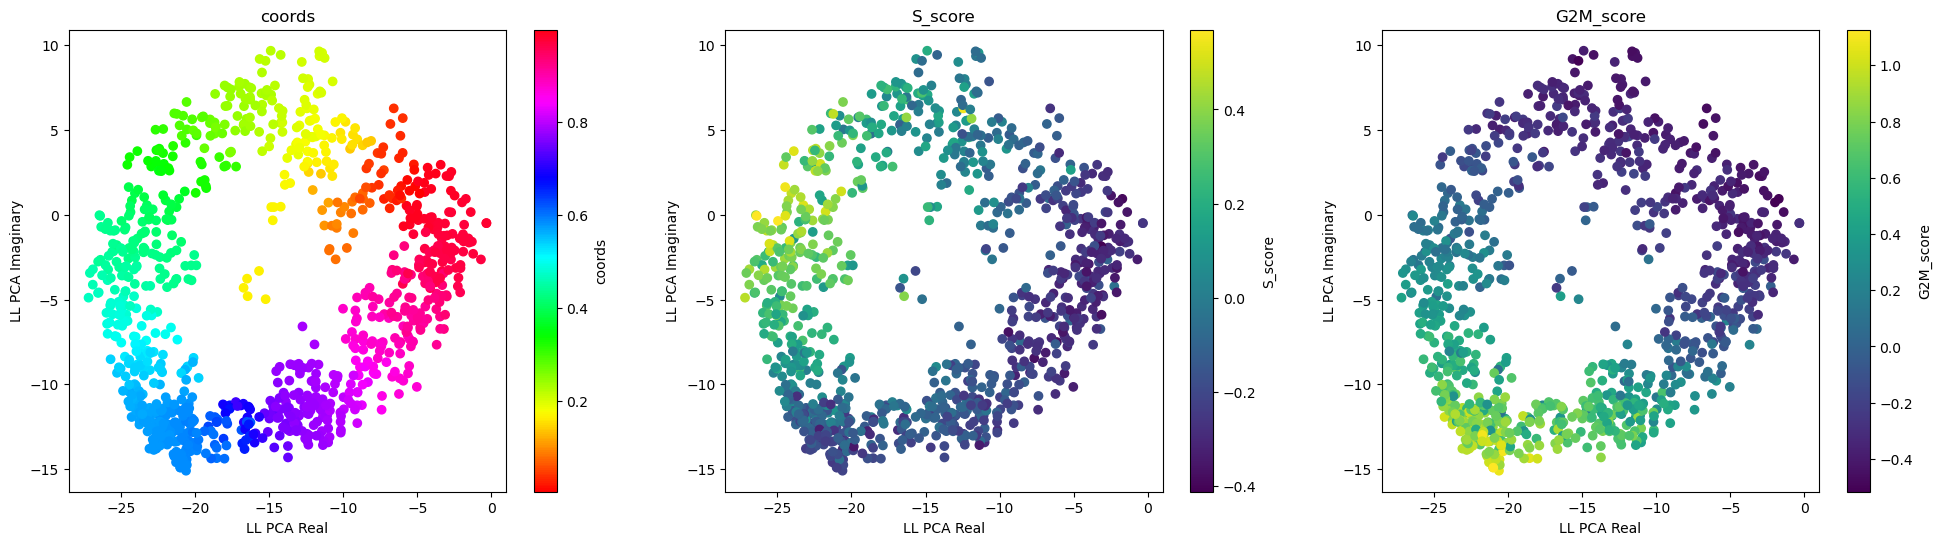

In [118]:
chnt.plot_2d(sub, c = ['coords', 'S_score', 'G2M_score'], mode = 'll')

/Users/kelly/Documents/code/chunter2/src/chunter/chunter.py:1435: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/Users/kelly/Documents/code/chunter2/src/chunter/chunter.py:1465: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



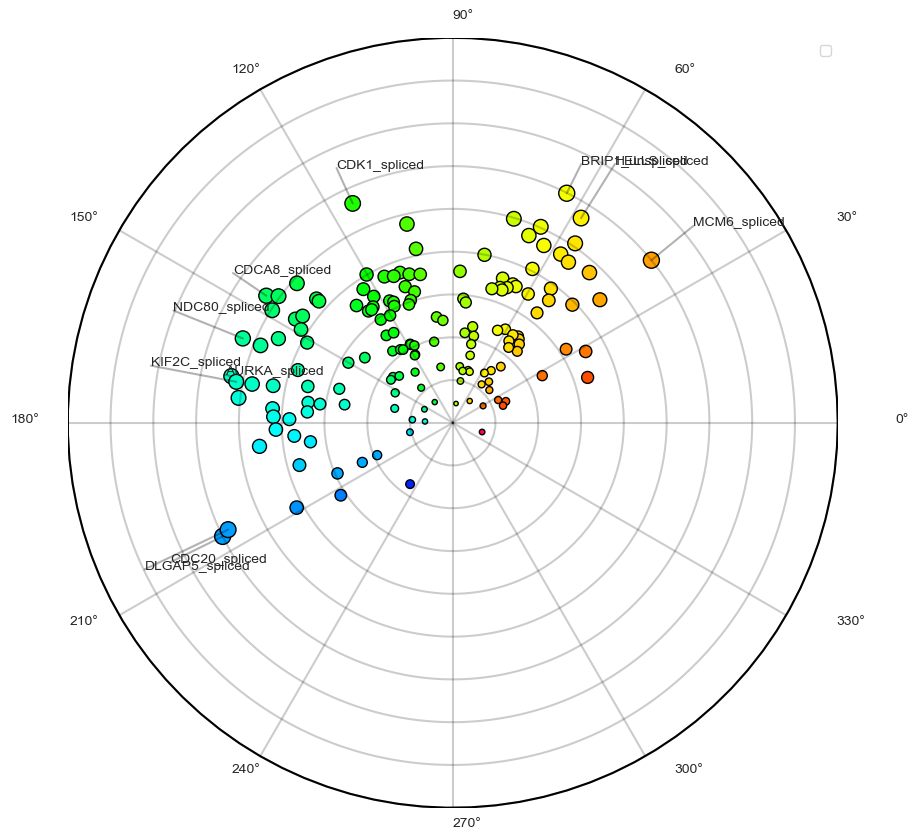

In [147]:
chnt.phase_plot(sub)

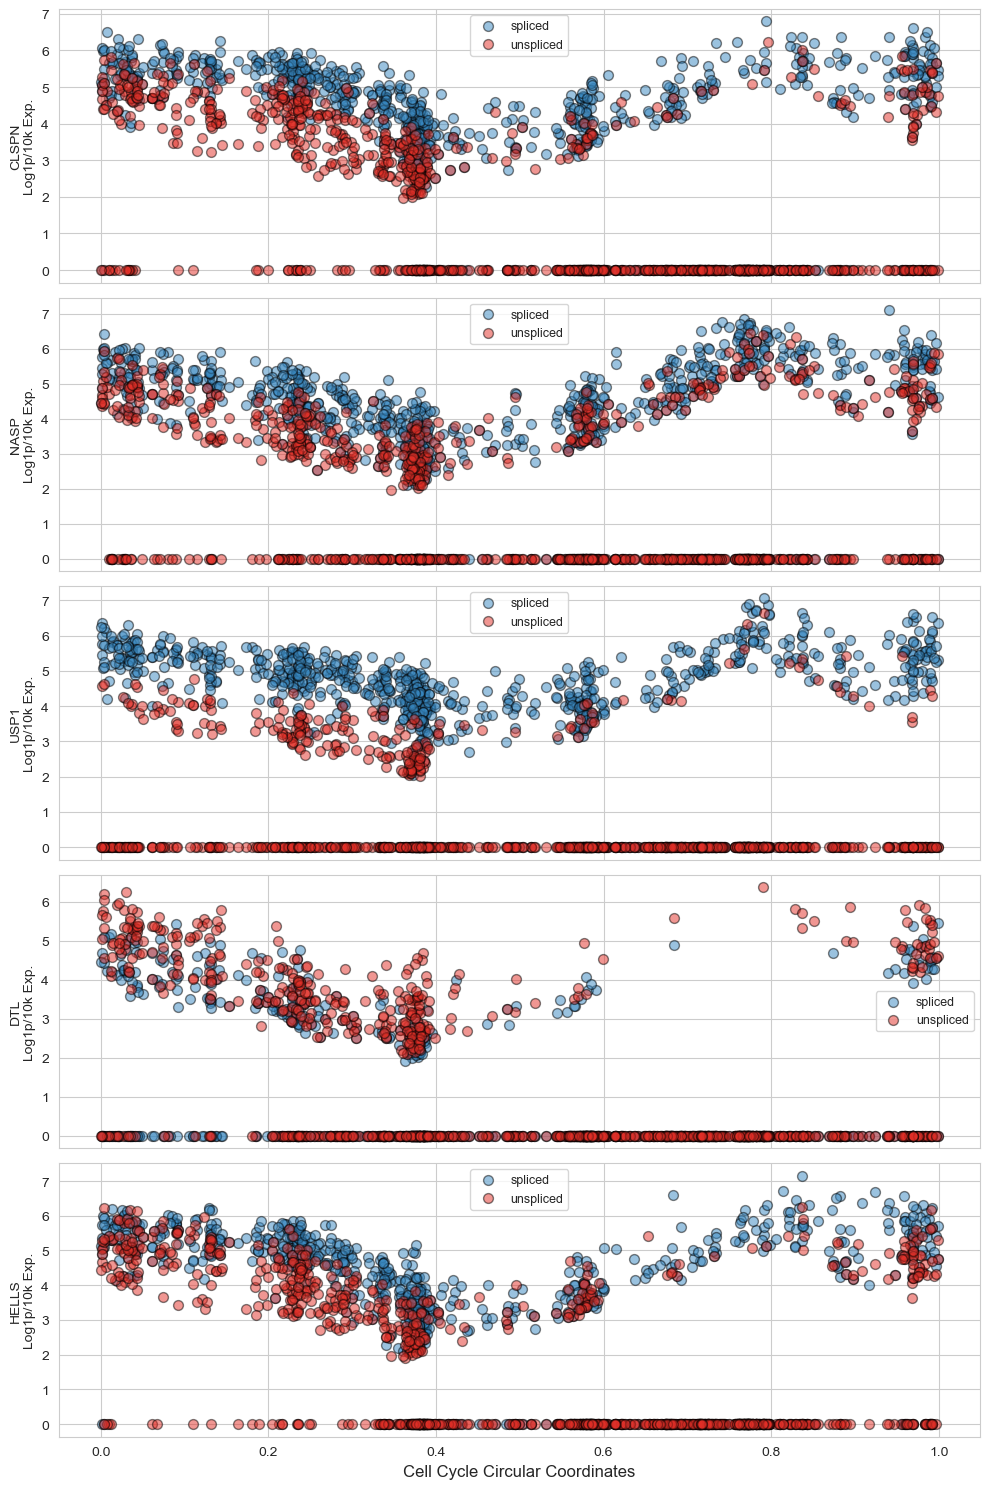

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean background style
sns.set_style("whitegrid")

# List of genes to plot (modify as needed)
genes = s_genes[:5]

# Extract the first color from the 'Blues_d' and 'Reds_d' palettes
color_blue = sns.color_palette("Blues_d", n_colors=1)[0]
color_red = sns.color_palette("Reds_d", n_colors=1)[0]

# Create subplots for each gene (each with its own y-axis) while sharing the same x-axis
fig, axes = plt.subplots(nrows=len(genes), ncols=1, figsize=(10, 3 * len(genes)), sharex=True)
if len(genes) == 1:
    axes = [axes]

# Loop over each gene and plot its spliced (blue) and unspliced (red) expression values
for ax, gene in zip(axes, genes):
    spliced_gene = f"{gene}_spliced"
    unspliced_gene = f"{gene}_unspliced"
    
    # Plot spliced data with the extracted blue color
    ax.scatter(sub.obs['coords'], sub[:, spliced_gene].X,
               s=50, edgecolors='black', alpha=0.5, color=color_blue, label='spliced')
    
    # Plot unspliced data with the extracted red color
    ax.scatter(sub.obs['coords'], sub[:, unspliced_gene].X,
               s=50, edgecolors='black', alpha=0.5, color=color_red, label='unspliced')
    
    # Label the y-axis with the gene name and expression details
    ax.set_ylabel(f'{gene}\nLog1p/10k Exp.', fontsize=10)
    
    # Add a legend to the subplot
    ax.legend(loc='best', fontsize=9)

# Label the shared x-axis on the bottom subplot
axes[-1].set_xlabel('Cell Cycle Circular Coordinates', fontsize=12)

# Adjust the layout to avoid overlaps
plt.tight_layout()
plt.show()




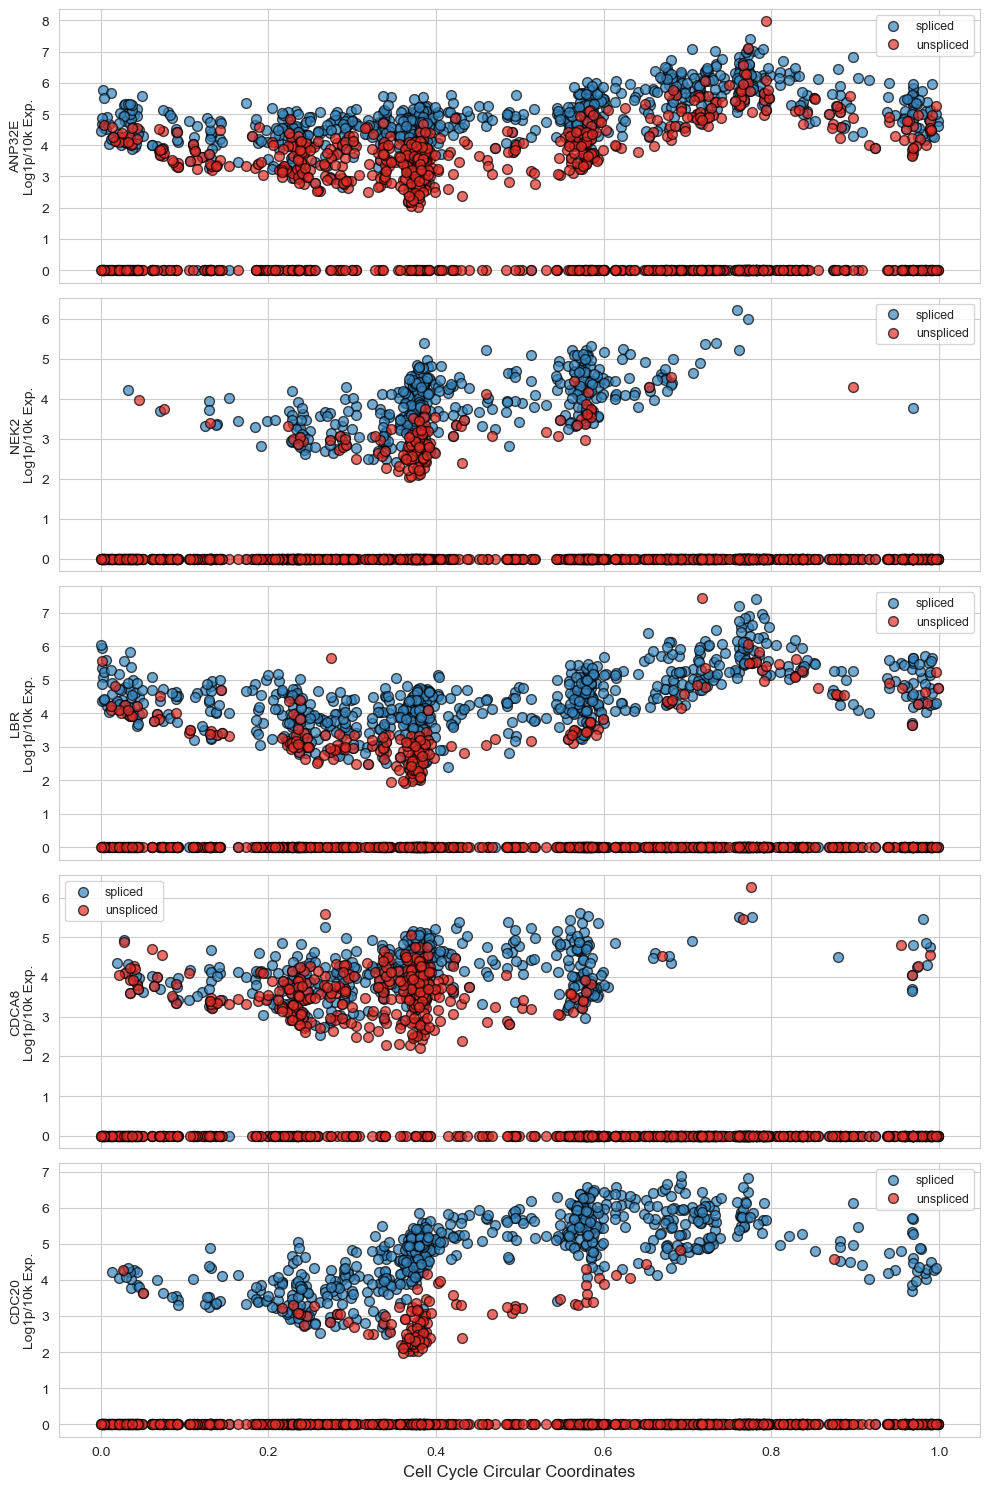

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean background style
sns.set_style("whitegrid")

# List of genes to plot (modify as needed)
genes = g2m_genes[:5]

# Extract the first color from the 'Blues_d' and 'Reds_d' palettes
color_blue = sns.color_palette("Blues_d", n_colors=1)[0]
color_red = sns.color_palette("Reds_d", n_colors=1)[0]

# Create subplots for each gene (each with its own y-axis) while sharing the same x-axis
fig, axes = plt.subplots(nrows=len(genes), ncols=1, figsize=(10, 3 * len(genes)), sharex=True)
if len(genes) == 1:
    axes = [axes]

# Loop over each gene and plot its spliced (blue) and unspliced (red) expression values
for ax, gene in zip(axes, genes):
    spliced_gene = f"{gene}_spliced"
    unspliced_gene = f"{gene}_unspliced"
    
    # Plot spliced data with the extracted blue color
    ax.scatter(sub.obs['coords'], sub[:, spliced_gene].X,
               s=50, edgecolors='black', alpha=0.7, color=color_blue, label='spliced')
    
    # Plot unspliced data with the extracted red color
    ax.scatter(sub.obs['coords'], sub[:, unspliced_gene].X,
               s=50, edgecolors='black', alpha=0.7, color=color_red, label='unspliced')
    
    # Label the y-axis with the gene name and expression details
    ax.set_ylabel(f'{gene}\nLog1p/10k Exp.', fontsize=10)
    
    # Add a legend to the subplot
    ax.legend(loc='best', fontsize=9)

# Label the shared x-axis on the bottom subplot
axes[-1].set_xlabel('Cell Cycle Circular Coordinates', fontsize=12)

# Adjust the layout to avoid overlaps
plt.tight_layout()
plt.show()



In [140]:
chnt.reparametrize(sub,-0.2)

AnnData object with n_obs × n_vars = 984 × 158
    obs: 'n_genes', 'n_counts', 'S_score', 'G2M_score', 'phase', 'density', 'coords', 'log_counts', 'density_iter_1', 'density_iter_2', 'density_iter_3'
    var: 'gene_phase', 'gene_amp'
    uns: 'log1p', 'pca', 'circular', 'leadlag', 'leadlag_eigvals'
    obsm: 'X_pca'
    varm: 'PCs', 'leadlag_pcs'
    layers: 'h_recenter'

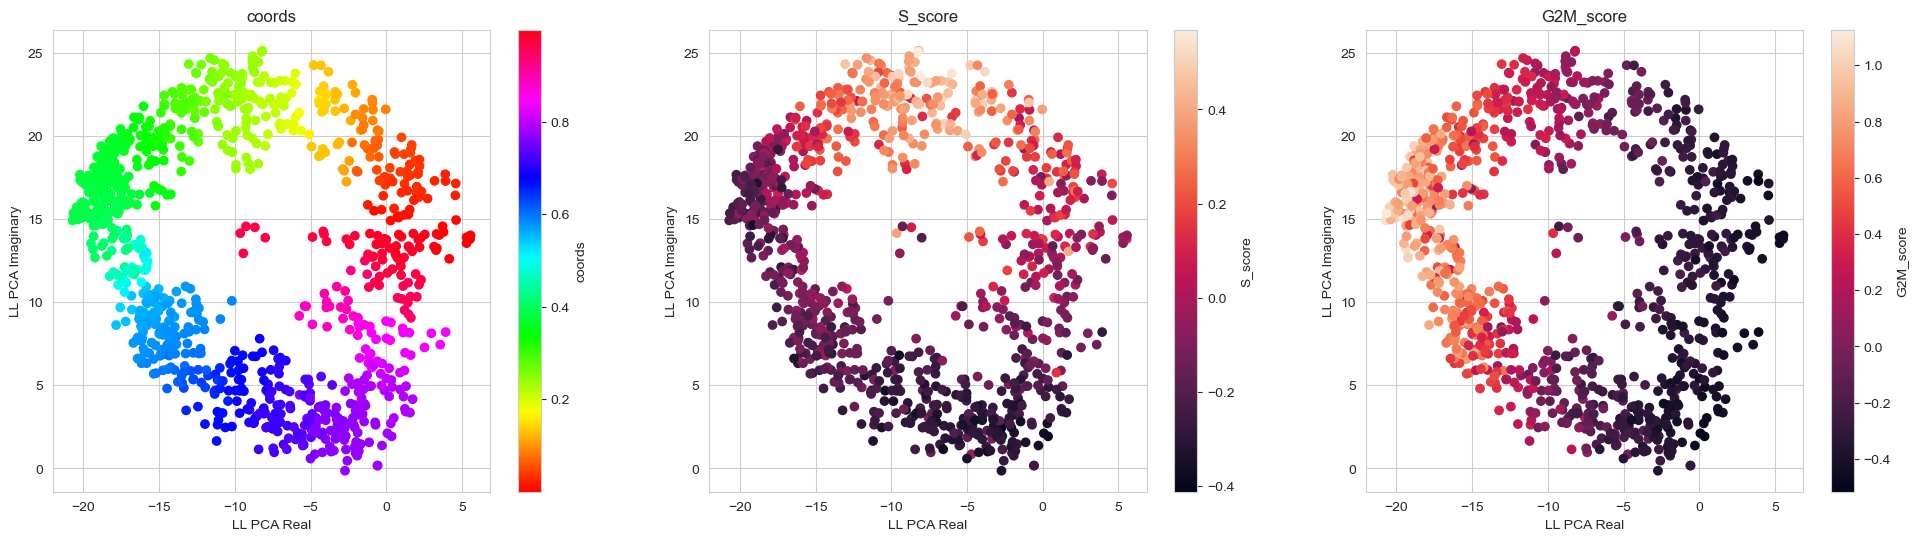

In [141]:
chnt.plot_2d(sub, c = ['coords', 'S_score', 'G2M_score'])

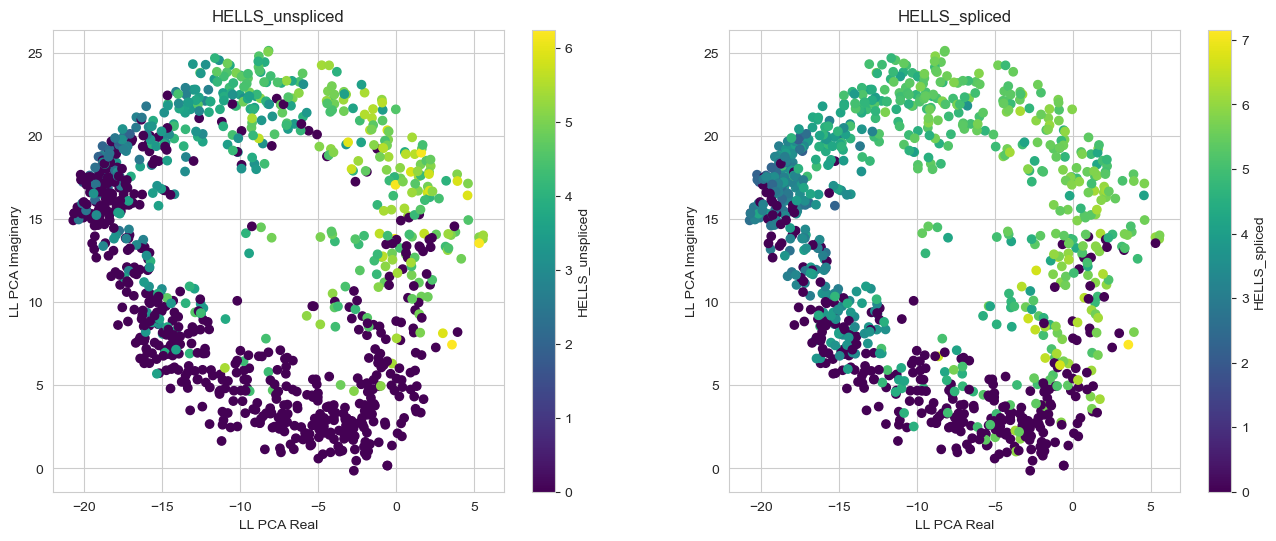

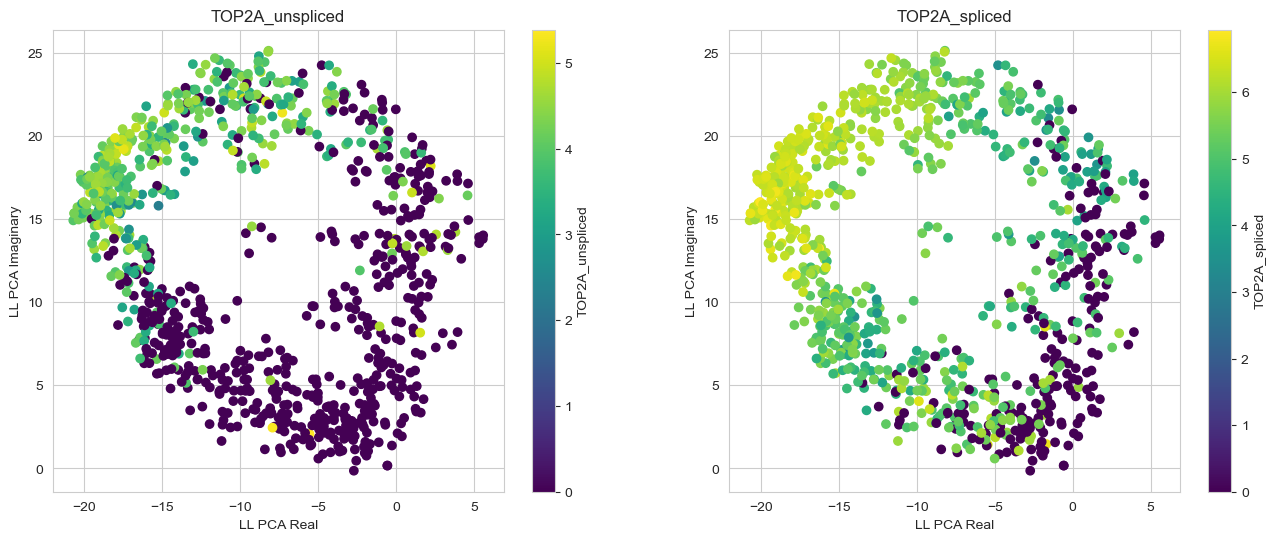

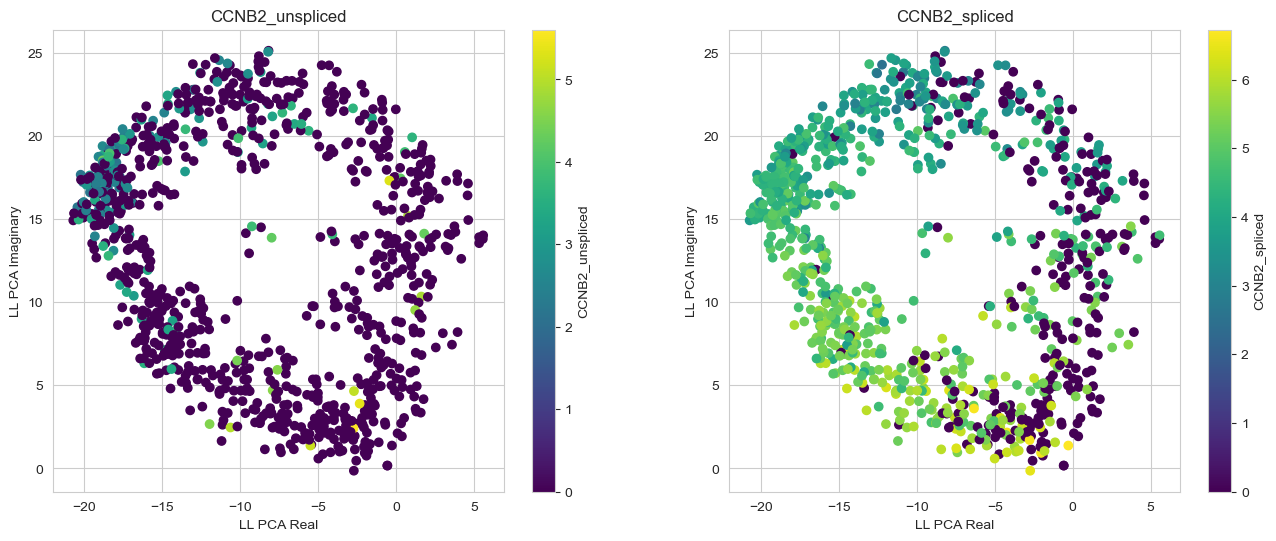

In [143]:
chnt.plot_2d(sub, c = ['HELLS_unspliced','HELLS_spliced'], mode = 'll')

chnt.plot_2d(sub, c = ['TOP2A_unspliced','TOP2A_spliced'], mode = 'll')

chnt.plot_2d(sub, c = ['CCNB2_unspliced','CCNB2_spliced'], mode = 'll')

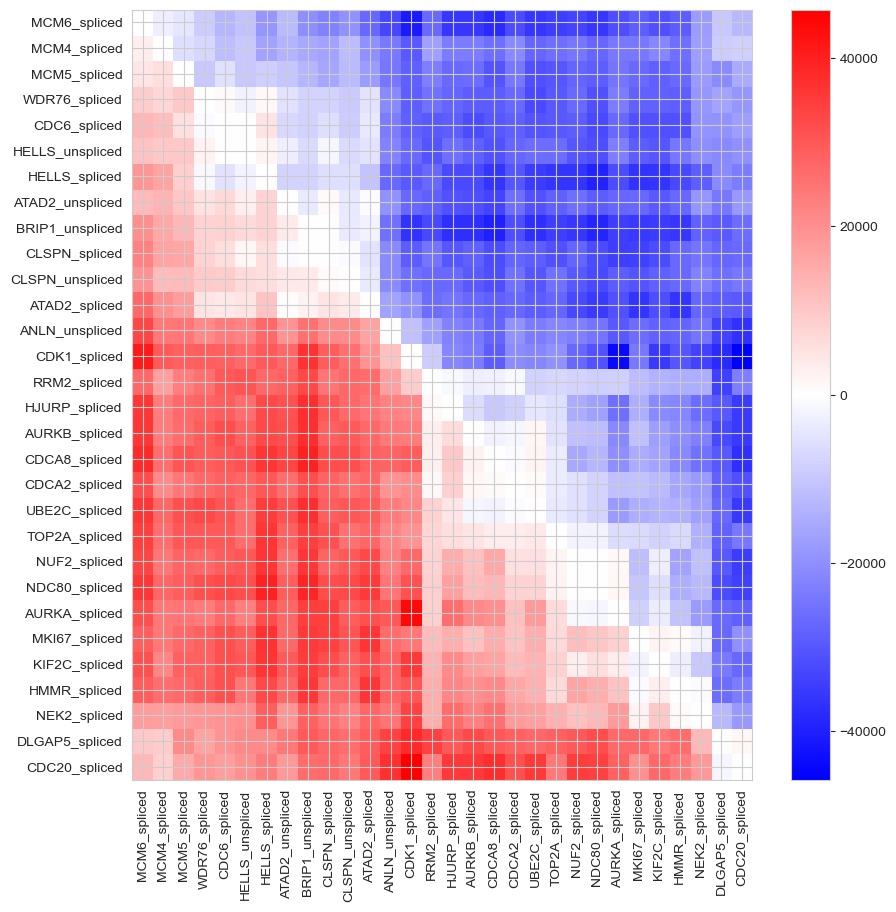

In [144]:
chnt.leadlag_plot(sub, k = 30)

In [145]:
shifts = []
# phase shifts
for gene in adata_cc.var_names:
    spl = list(sub[:,str( gene + '_spliced')].var['gene_phase'])[0]
    uns = list(sub[:,str( gene + '_unspliced')].var['gene_phase'])[0]
    shifts.append( (spl-uns) % np.pi )

### Calculate estimated phase shifts of spliced vs unspliced genes

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

<>:9: SyntaxWarning:

invalid escape sequence '\p'

/var/folders/y7/jfktb_mn4qv99x02_jgb72tw0000gn/T/ipykernel_25944/3180022530.py:9: SyntaxWarning:

invalid escape sequence '\p'

/var/folders/y7/jfktb_mn4qv99x02_jgb72tw0000gn/T/ipykernel_25944/3180022530.py:9: SyntaxWarning:

invalid escape sequence '\p'

/var/folders/y7/

Text(0.5, 0, 'Gene')

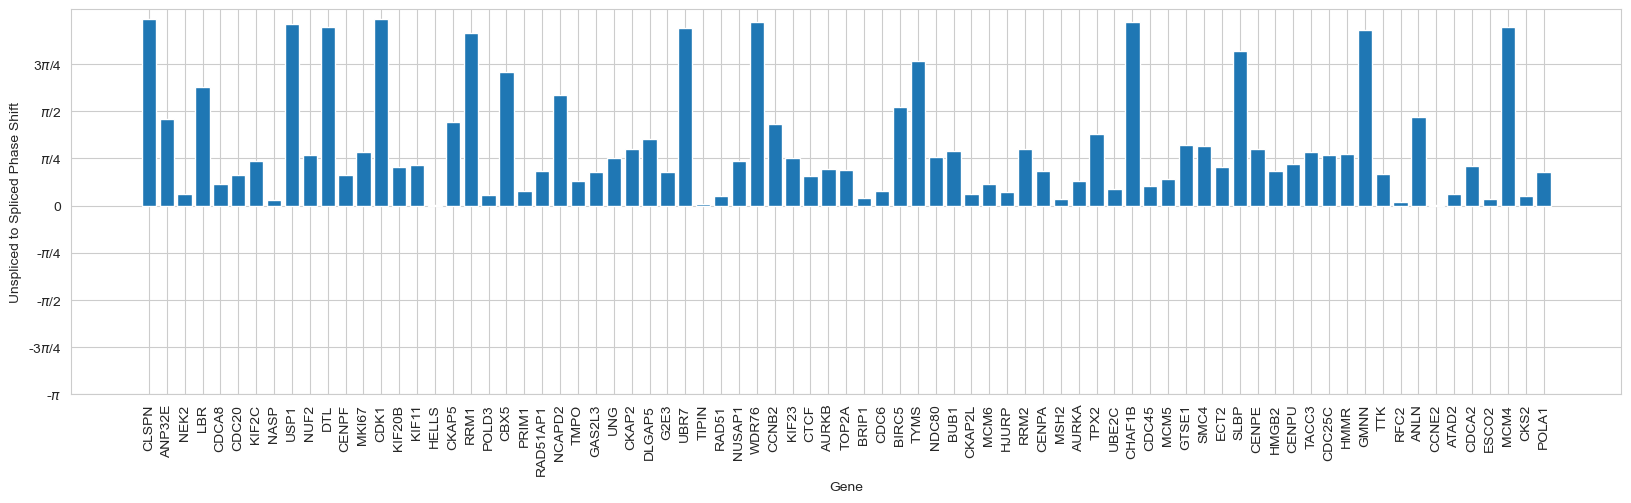

In [146]:
# make it bigger so you can see all of the names on the x axis
plt.figure(figsize = (20,5))

# plot barchart of pjhase sjhifts
plt.bar(adata_cc.var_names, shifts)


# change y-axis ticks to multiples of a quarter pi
plt.yticks(np.arange(-np.pi, np.pi, np.pi/4), labels = ['-$\pi$', '-3$\pi$/4', '-$\pi$/2', '-$\pi$/4', '0', '$\pi$/4', '$\pi$/2', '3$\pi$/4'])

# rotate names 
plt.xticks(rotation = 90)

# label y axis
plt.ylabel('Unspliced to Spliced Phase Shift')

# label x axis
plt.xlabel('Gene')

We can also see that the unspliced RNA expression levels all lead the spliced RNA expression levels. This is expected since the unspliced RNA is the precursor to the spliced RNA.

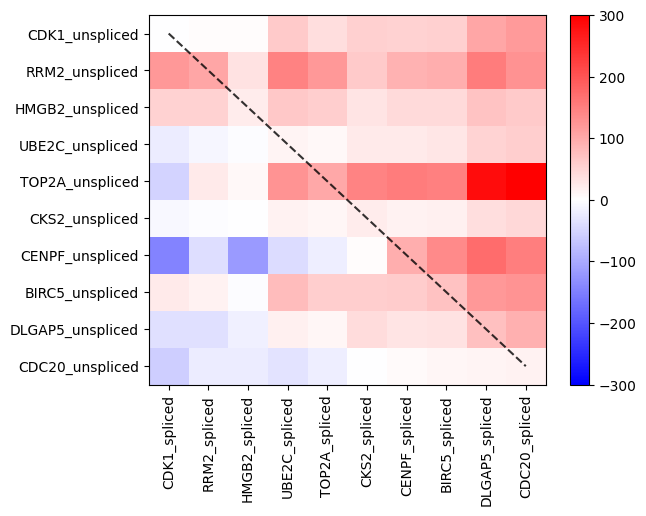

In [144]:
# get indices of the top genes
llm = sub.uns['leadlag']
top_gene_indices = [list(sub.var_names).index(x) for x in total_top_genes]
llm = llm[top_gene_indices]
llm = llm[:, top_gene_indices]

# plot a heatmap of llm labelling x and y axis by total_top_genes
plt.imshow(llm[:10,10:]/10, cmap = 'bwr', aspect = 'auto', interpolation='nearest')


# add a colorbar between 300 and -300
plt.colorbar()

# change range of the color
plt.clim(-300, 300)


# label x axis and remove ticks
plt.xticks(ticks = np.arange(0,10), labels = sub.var_names[top_gene_indices][10:], rotation = 90)

plt.yticks(ticks = np.arange(0,10), labels = sub.var_names[top_gene_indices][:10])

# hightlight the diagonal
plt.plot([0,9], [0,9], color = 'black', linestyle = '--', alpha = 0.8)